In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from scipy.ndimage import median_filter
from scipy.signal import welch, csd
from scipy.optimize import curve_fit
import glob
from windrose import WindroseAxes
import cmcrameri as cmc
from cmcrameri import cm
from scipy.stats import linregress
import sys
import os
from pathlib import Path
import pickle
from datetime import datetime

# Add project 'src' directory to sys.path when running from the notebooks/ folder
# (notebooks/ is expected to be inside the repo; repo_root = parent of cwd)
repo_root = Path.cwd().parent
src_path = str(repo_root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import modules from the installed package. If this fails, the editable install
# (`pip install -e .`) may be missing or kernel needs restart.
try:
    from ec.func_read_data import *
    from ec.func_coherence import *
    from mo.func_mo import *
    from spc.normalize import *
    from plotting.funcs_plots import *
except Exception as e:
    print('Package import failed:', e)
    print('Make sure you ran `pip install -e .` (editable install) and restart the kernel, or that src/ exists at:', src_path)
else:
    # For development: auto-reload modules (keep this enabled while editing source files)
    %load_ext autoreload
    %autoreload 2

In [2]:

def load_fastdata(folder, start, end):
    start_dt = datetime.strptime(start, '%Y-%m-%d_%H:%M:%S')
    end_dt = datetime.strptime(end, '%Y-%m-%d_%H:%M:%S')
    all_dfs = []
    for root, dirs, files in os.walk(folder):
        files = sorted(files)
        for file in files:
            if file.endswith('.dat'):
                try:
                    date_str = file.split('_')[-2] + '_' + file.split('_')[-1].split('.')[0]
                    file_dt = datetime.strptime(date_str, '%Y-%m-%d_%H%M')
                    if start_dt <= file_dt <= end_dt:
                        file_path = os.path.join(root, file)
                        # print(f"Processing file: {file_path}")
                        df = pd.read_csv(file_path, index_col=0, parse_dates=True, sep='\t')
                        df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
                        all_dfs.append(df)
                except Exception:
                    pass
    if all_dfs:
        return pd.concat(all_dfs)
    else:
        return pd.DataFrame()
    
def load_fastdata_nDR(folder, start, end):
    start_dt = datetime.strptime(start, '%Y-%m-%d_%H:%M:%S')
    end_dt = datetime.strptime(end, '%Y-%m-%d_%H:%M:%S')
    all_dfs = []
    for root, dirs, files in os.walk(folder):
        files = sorted(files)
        for file in files:
            if file.endswith('.dat'):
                try:
                    date_str = file.split('_')[-2] + '_' + file.split('_')[-1].split('.')[0]
                    file_dt = datetime.strptime(date_str, '%Y-%m-%d_%H%M')
                    if start_dt <= file_dt <= end_dt:
                        file_path = os.path.join(root, file)
                        # print(f"Processing file: {file_path}")
                        df = pd.read_csv(file_path, index_col=0, sep='\t')
                        df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')  # Parse index first
                        df = df.drop(df.index[0])  # Drop first row after headers
                        df = df.apply(pd.to_numeric, errors='coerce')  # Convert data columns to numeric
                        all_dfs.append(df)
                except Exception:
                    pass
    if all_dfs:
        return pd.concat(all_dfs)
    else:
        return pd.DataFrame()



In [5]:
# Helper function to safely convert frequency to period
def freq_to_period(f):
    """Convert frequency to period, avoiding division by zero warnings."""
    return np.divide(1, f, out=np.full_like(f, np.nan), where=(f > 0))

Loaded synoptic: 33 periods from wd1_45_100_periods.pkl
Loaded katabatic: 29 periods from wd1_110_180_periods.pkl
Error during synoptic event 2024-07-20_05:40:00 to 2024-07-20_20:47:00: `ydata` must not be empty!
Error during synoptic event 2024-08-06_08:01:00 to 2024-08-07_20:33:00: `ydata` must not be empty!
Error during synoptic event 2024-08-23_18:46:00 to 2024-08-24_19:32:00: `ydata` must not be empty!
Error during synoptic event 2024-08-26_06:08:00 to 2024-08-26_20:20:00: `ydata` must not be empty!
Error during synoptic event 2024-08-27_20:52:00 to 2024-08-28_15:15:00: `ydata` must not be empty!
Skipping synoptic event 2024-12-01_01:01:00 to 2024-12-02_09:24:00 due to empty data.
Skipping synoptic event 2024-12-02_09:25:00 to 2024-12-02_23:05:00 due to empty data.
Skipping synoptic event 2024-12-03_06:37:00 to 2024-12-03_23:25:00 due to empty data.
Skipping synoptic event 2024-12-04_02:23:00 to 2024-12-04_17:41:00 due to empty data.
Skipping synoptic event 2024-12-08_05:20:00 to 

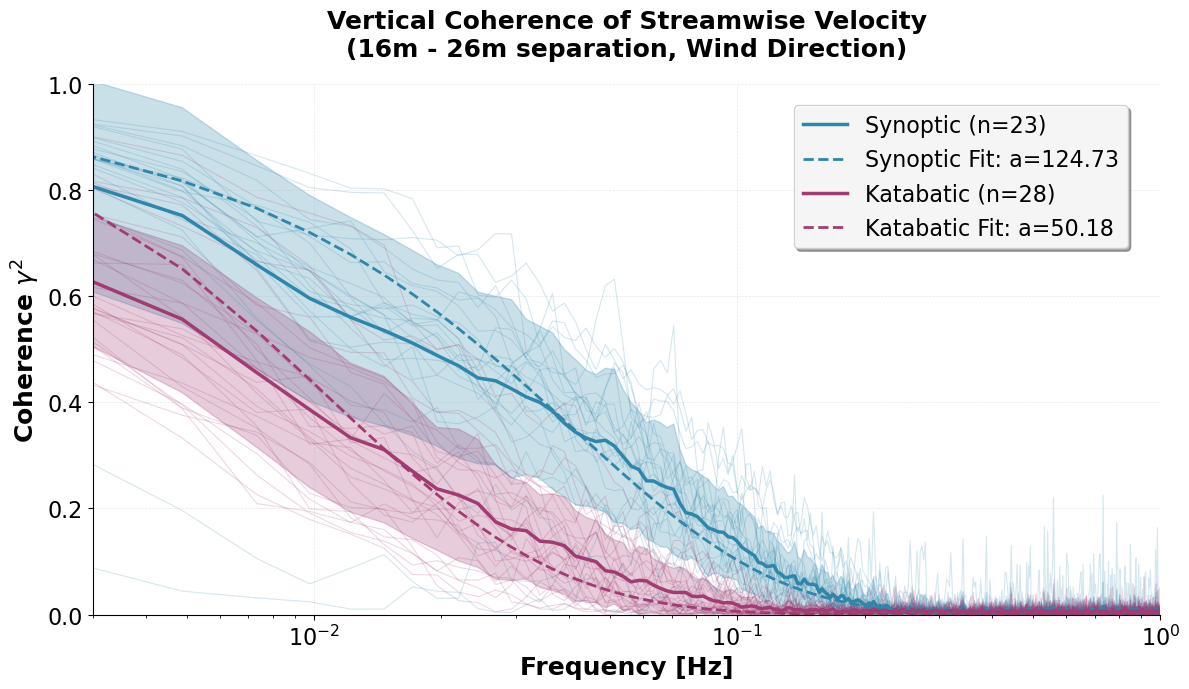


Plot saved to: ../plots/plots_coherence/10_wind_direction_synoptic_katabatic_16m_26m.png
Filter type: wind_direction
  synoptic: 23 events processed
  katabatic: 28 events processed
Loaded neutral: 46 periods from stability_01_01_periods.pkl
Loaded stable: 49 periods from stability_015_10_periods.pkl
Loaded unstable: 0 periods from stability_10_01_periods.pkl


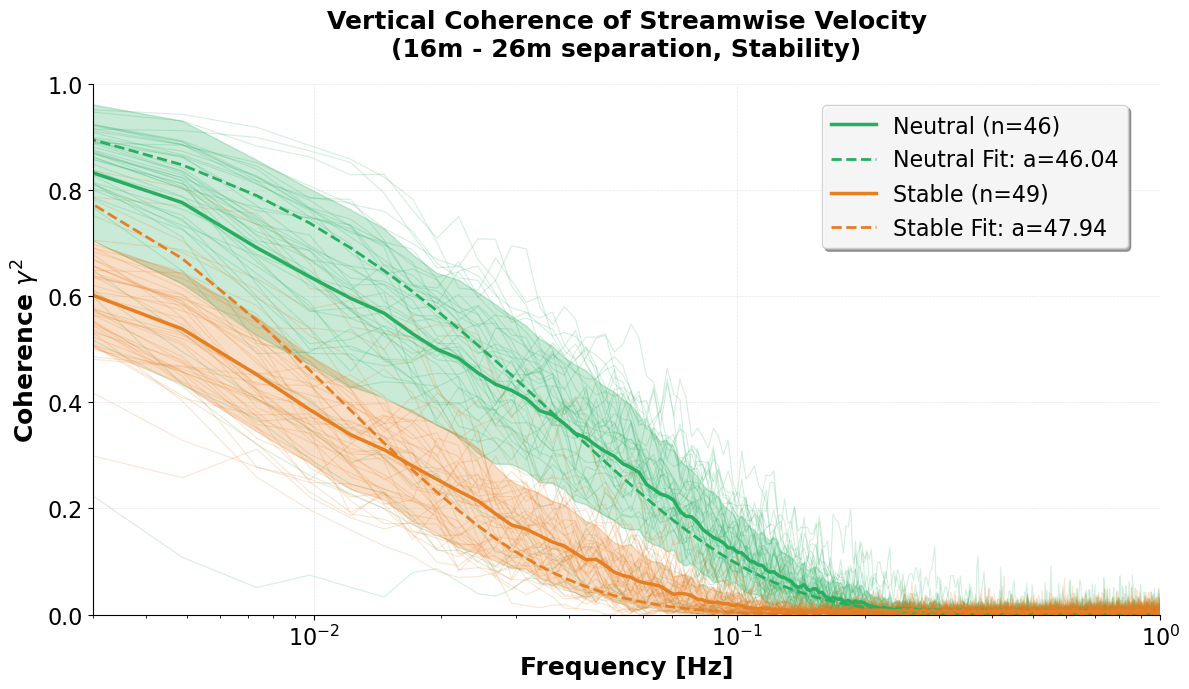


Plot saved to: ../plots/plots_coherence/10_stability_neutral_stable_unstable_16m_26m.png
Filter type: stability
  neutral: 46 events processed
  stable: 49 events processed
  unstable: 0 events processed
Loaded with_BS: 29 periods from BS_periods.pkl
Loaded without_BS: 64 periods from noBS_periods.pkl
Error during with_BS event 2024-07-20_12:00:00 to 2024-07-21_00:00:00: `ydata` must not be empty!
Error during with_BS event 2024-08-05_00:00:00 to 2024-08-05_12:00:00: `ydata` must not be empty!
Error during with_BS event 2024-08-07_00:00:00 to 2024-08-08_12:00:00: `ydata` must not be empty!
Error during with_BS event 2024-08-24_00:00:00 to 2024-08-25_00:00:00: `ydata` must not be empty!
Error during with_BS event 2024-08-26_00:00:00 to 2024-08-28_12:00:00: `ydata` must not be empty!
Skipping with_BS event 2024-12-01_00:00:00 to 2024-12-03_00:00:00 due to empty data.
Skipping with_BS event 2024-12-03_12:00:00 to 2024-12-04_12:00:00 due to empty data.
Error during without_BS event 2024-0

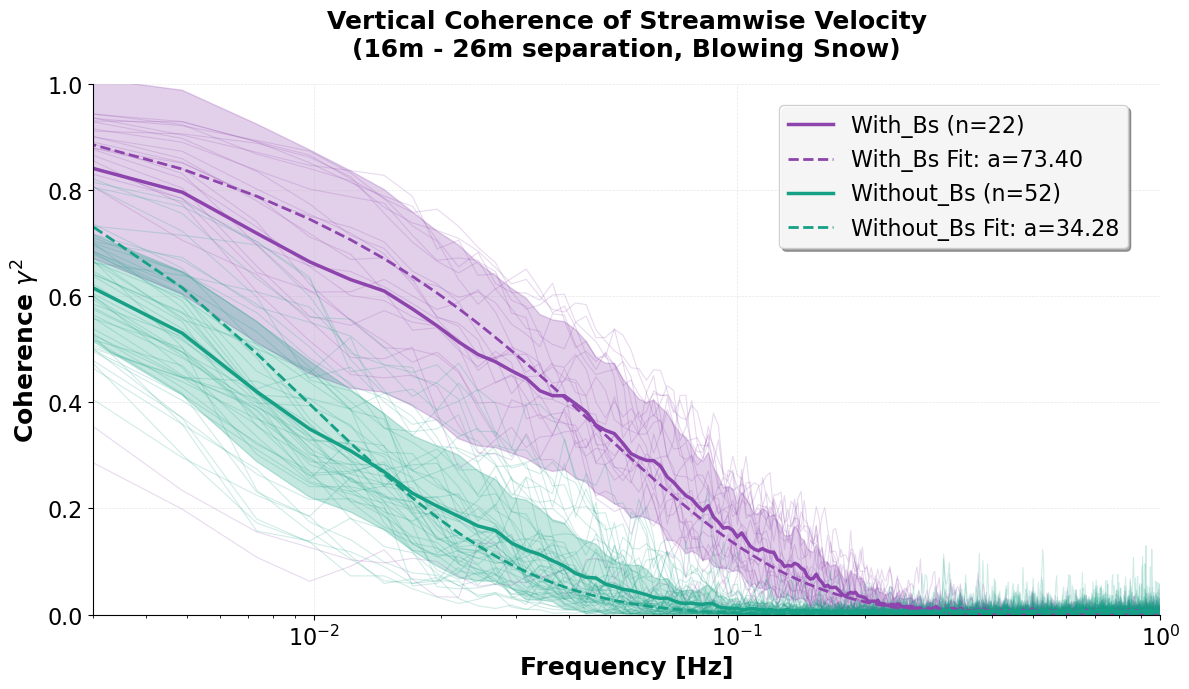


Plot saved to: ../plots/plots_coherence/10_blowing_snow_with_BS_without_BS_16m_26m.png
Filter type: blowing_snow
  with_BS: 22 events processed
  without_BS: 52 events processed


In [7]:
# ========== CONFIGURATION ==========
# Configure which heights to analyze
lower_height_folder = '/home/engbers/Documents/PhD/EC_data_convert/SFC_DR/'
upper_height_folder = '/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m_DR/'
vertical_separation_m = 14  # meters between sensors
lower_height_label = '2m'
upper_height_label = '16m'

# Alternative height configurations (uncomment to use):
# For 16m - 26m:
lower_height_folder = '/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m_DR/'
upper_height_folder = '/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_DR/'
vertical_separation_m = 10
lower_height_label = '16m'
upper_height_label = '26m'

# ========== FILTER CONFIGURATION ==========
# Choose ONE filter type: 'wind_direction', 'stability', or 'blowing_snow'
filter_type = 'wind_direction'  # Options: 'wind_direction', 'stability', 'blowing_snow'

# Wind Direction Filter (only used if filter_type = 'wind_direction')
# Available files: 'wd1_45_90_periods.pkl', 'wd1_90_180_periods.pkl'
wind_direction_filters = {
    'synoptic': 'wd1_45_100_periods.pkl',
    'katabatic': 'wd1_110_180_periods.pkl'
}

# Stability Filter (only used if filter_type = 'stability')
# Available files: 'stability_0_02_periods.pkl', 'stability_02_10_periods.pkl', 'stability_10_01_periods.pkl'.
stability_filters = {
    'neutral': 'stability_01_01_periods.pkl',
    'stable': 'stability_015_10_periods.pkl',
    'unstable': 'stability_10_01_periods.pkl'
}

# Blowing Snow Filter (only used if filter_type = 'blowing_snow')
# This uses the find_consecutive_periods function from plotting.funcs_plots
blowing_snow_filters = {
    'with_BS': 'BS_periods.pkl',
    'without_BS': 'noBS_periods.pkl'
}

# Color scheme for different categories
color_scheme = {
    # Wind direction colors
    'synoptic': {'main': '#2E86AB', 'fill': '#2E86AB', 'alpha': 0.25},
    'katabatic': {'main': '#A23B72', 'fill': '#A23B72', 'alpha': 0.25},
    # Stability colors
    'neutral': {'main': '#27AE60', 'fill': '#27AE60', 'alpha': 0.25},
    'stable': {'main': '#E67E22', 'fill': '#E67E22', 'alpha': 0.25},
    'unstable': {'main': '#E74C3C', 'fill': '#E74C3C', 'alpha': 0.25},
    # Blowing snow colors
    'with_BS': {'main': '#8E44AD', 'fill': '#8E44AD', 'alpha': 0.25},
    'without_BS': {'main': '#16A085', 'fill': '#16A085', 'alpha': 0.25}
}

# ====================================
for filter_type in ['wind_direction', 'stability', 'blowing_snow']:
    # Load event data based on filter type
    events_folder = '/home/engbers/Documents/Github/DataProcessingScripts/events/'
    events_data = {}

    if filter_type == 'wind_direction':
        filters_to_use = wind_direction_filters
        colors = {k: color_scheme[k] for k in wind_direction_filters.keys()}
    elif filter_type == 'stability':
        filters_to_use = stability_filters
        colors = {k: color_scheme[k] for k in stability_filters.keys()}
    elif filter_type == 'blowing_snow':
        filters_to_use = blowing_snow_filters
        colors = {k: color_scheme[k] for k in blowing_snow_filters.keys()}
    else:
        raise ValueError(f"Invalid filter_type: {filter_type}. Choose 'wind_direction', 'stability', or 'blowing_snow'")

    # Load period files for wind_direction and stability
    if filter_type in ['wind_direction', 'stability', 'blowing_snow']:
        for category, filename in filters_to_use.items():
            filepath = events_folder + filename
            try:
                with open(filepath, 'rb') as f:
                    events_data[category] = pickle.load(f)
                print(f"Loaded {category}: {len(events_data[category])} periods from {filename}")
            except FileNotFoundError:
                print(f"Warning: {filepath} not found. Skipping {category}.")
                events_data[category] = []

    # Set up the figure with scientific styling
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Store all coherence curves and wind speeds for each category
    coherence_data = {category: {'coh': [], 'period': [], 'u_mean': [], 'a_best': [], 'y': []} 
                    for category in filters_to_use.keys()}

    # Process periods for each category
    for category in filters_to_use.keys():
        periods = events_data.get(category, [])
        for period_start, period_end in periods:
            start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
            end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
            
            try:
                df_lower = load_fastdata(lower_height_folder, start_str, end_str)
                df_upper = load_fastdata(upper_height_folder, start_str, end_str)
                
                if df_lower.empty or df_upper.empty:
                    print(f"Skipping {category} event {start_str} to {end_str} due to empty data.")
                    continue
                    
                u1, u2 = df_lower['Ux'], df_upper['Ux']
                
                # Align and clean data
                u1_clean, u2_clean = u1.align(u2, join='inner')
                mask = (~u1_clean.isna()) & (~u2_clean.isna())
                u1_clean = u1_clean[mask]
                u2_clean = u2_clean[mask]
                
                # Store mean wind speed for this event
                event_u_mean = ((u1_clean + u2_clean) / 2).mean()
                coherence_data[category]['u_mean'].append(event_u_mean)
                
                f, coh, y, a_best = compute_coherence(u1_clean, u2_clean, vertical_separation_m)
                period = f

                coherence_data[category]['coh'].append(coh)
                coherence_data[category]['period'].append(period)
                coherence_data[category]['a_best'].append(a_best)
                coherence_data[category]['y'].append(y)
                
                # Plot individual curves with low alpha
                ax.semilogx(period, coh, color=colors[category]['main'], alpha=0.2, linewidth=0.8)
                
            except Exception as e:
                print(f"Error during {category} event {start_str} to {end_str}: {e}")
                continue

    # Calculate and plot envelopes for each category
    for category in filters_to_use.keys():
        coh_list = coherence_data[category]['coh']
        period_list = coherence_data[category]['period']
        u_mean_list = coherence_data[category]['u_mean']
        
        if len(coh_list) > 0:
            coh_array = np.array([c for c in coh_list if c.size > 0])
            period_array = np.array([p for p in period_list if p.size > 0])
            
            if len(coh_array) > 0:
                period_ref = period_array[0]
                coh_mean = np.nanmean(coh_array, axis=0)
                coh_std = np.nanstd(coh_array, axis=0)
                a_best_mean = np.nanmean(coherence_data[category]['a_best'])
                y_mean = np.nanmean(coherence_data[category]['y'], axis=0)
                
                # Plot mean and envelope
                ax.semilogx(period_ref, coh_mean, color=colors[category]['main'], 
                        linewidth=2.5, label=f'{category.title()} (n={len(coh_list)})')
                ax.fill_between(period_ref, coh_mean - coh_std, coh_mean + coh_std, 
                            color=colors[category]['fill'], alpha=colors[category]['alpha'])

                # Fit theoretical curve to mean coherence
                f_ref = period_ref
                mask_fit = np.isfinite(coh_mean) & np.isfinite(f_ref)
                # u_mean_category = np.nanmean(u_mean_list)

                # y, a_best = compute_coherence_fit(u_mean_category, coh_mean[mask_fit], 
                                                #  vertical_separation_m, f_ref[mask_fit])
                ax.semilogx(period_ref[mask_fit], y_mean[mask_fit], '--', color=colors[category]['main'], 
                        linewidth=2, label=f'{category.title()} Fit: a={a_best_mean:.2f}')

    # Scientific formatting
    ax.set_xlabel('Frequency [Hz]', fontsize=18, fontweight='bold')
    ax.set_ylabel(r'Coherence $\gamma^2$', fontsize=18, fontweight='bold')

    plot_title = f'Vertical Coherence of Streamwise Velocity\n({lower_height_label} - {upper_height_label} separation, {filter_type.replace("_", " ").title()})'
    ax.set_title(plot_title, fontsize=18, fontweight='bold', pad=20)

    # Set axis limits and grid
    ax.set_xlim(3e-3,1)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)

    # Add legend
    legend = ax.legend(fontsize=16, frameon=True, fancybox=True, shadow=True, 
                    loc='upper right', bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)

    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    plt.tight_layout()

    # Generate filename based on configuration
    filter_str = '_'.join(filters_to_use.keys())
    plot_filename = f'../plots/plots_coherence/{vertical_separation_m}_{filter_type}_{filter_str}_{lower_height_label}_{upper_height_label}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()

    print(f"\nPlot saved to: {plot_filename}")
    print(f"Filter type: {filter_type}")
    for category, data in coherence_data.items():
        print(f"  {category}: {len(data['coh'])} events processed")

Processing period: 2024-09-19_08:30:00 to 2024-09-20_18:30:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


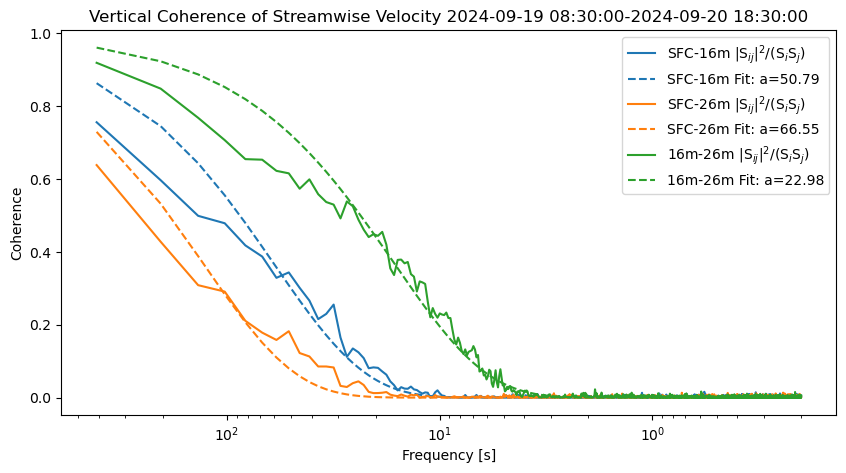

Processing period: 2024-10-16_02:30:00 to 2024-10-17_04:30:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


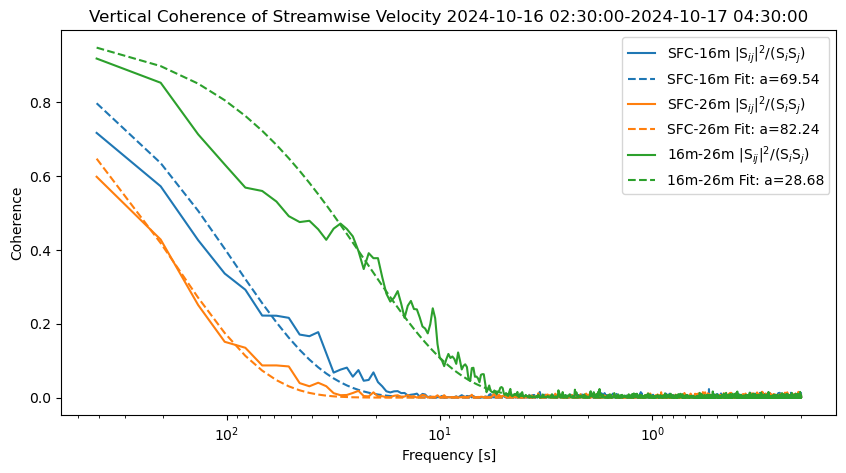

Processing period: 2024-10-28_16:00:00 to 2024-10-29_22:00:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


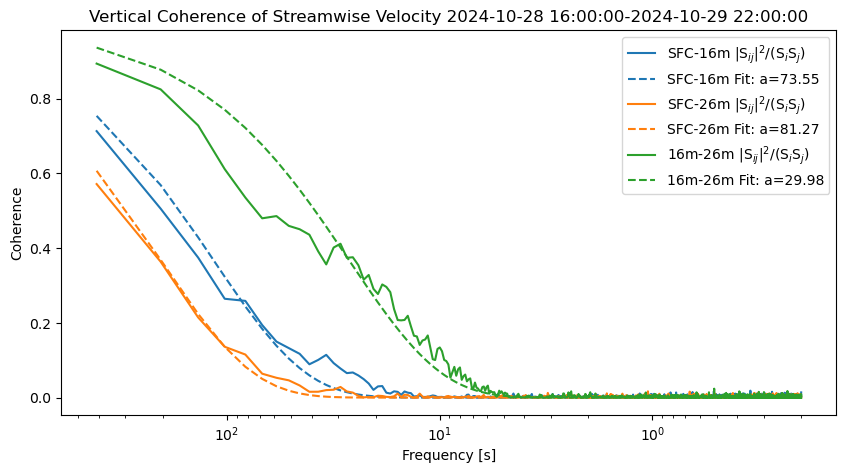

Processing period: 2024-04-18_19:00:00 to 2024-04-21_11:00:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


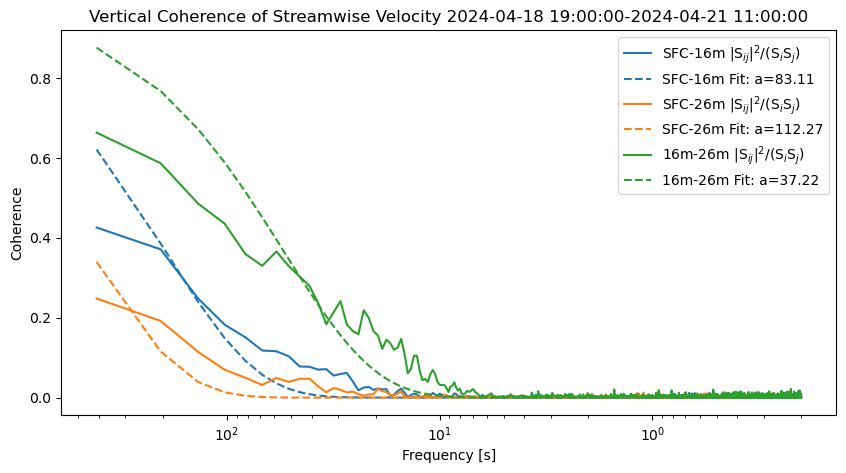

Processing period: 2024-06-08_22:00:00 to 2024-06-09_23:30:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


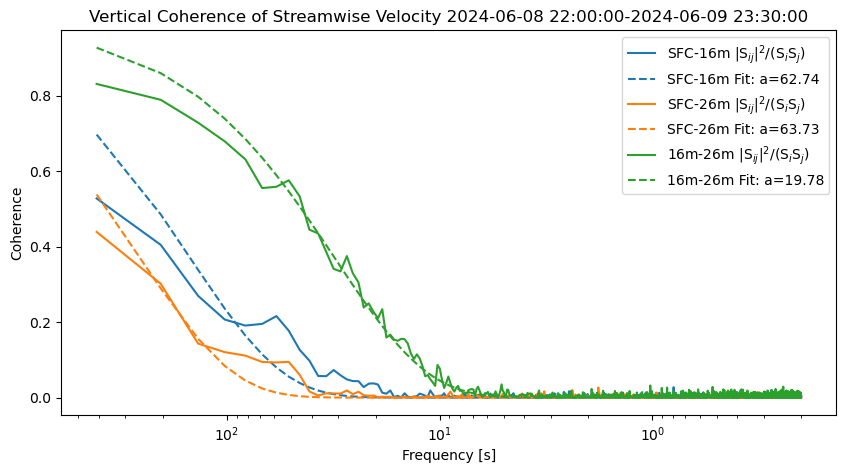

Processing period: 2024-11-06_13:30:00 to 2024-11-07_21:00:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


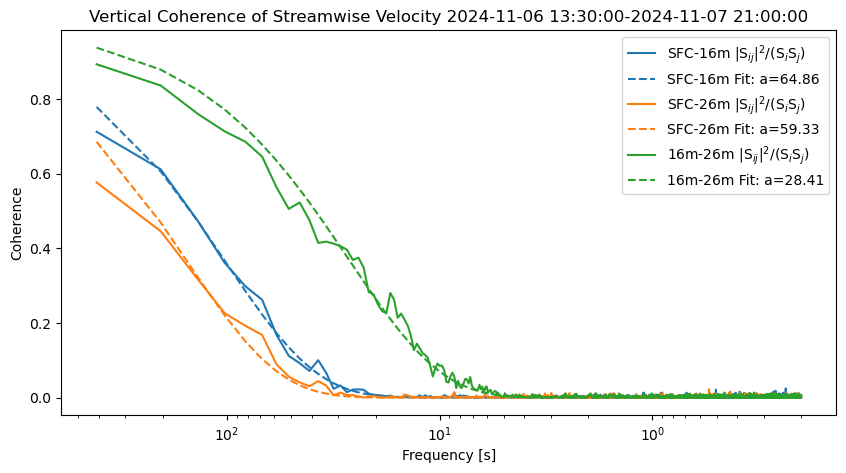

In [ ]:
with open('events.pkl', 'rb') as f:
    events = pickle.load(f)
    
for period_start, period_end in events:
    fastdata_SFC_periods = []
    fastdata_16_periods = []
    fastdata_26_periods = []
    start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
    end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
    print(f"Processing period: {start_str} to {end_str}")
    
    # Load and append data for each period
    sfc_df = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/SFC_DR/', start_str, end_str)
    fastdata_SFC_periods.append(sfc_df)
    df_16 = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m_DR/', start_str, end_str)
    fastdata_16_periods.append(df_16)
    df_26 = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_DR/', start_str, end_str)
    fastdata_26_periods.append(df_26)

    # After the loop, concatenate all periods into one continuous DataFrame for each height
    fastdata_SFC_all = pd.concat(fastdata_SFC_periods, axis=0)
    fastdata_16_all = pd.concat(fastdata_16_periods, axis=0)
    fastdata_26_all = pd.concat(fastdata_26_periods, axis=0)
    plt.figure(figsize=(10, 5))

    # Check if data is empty before plotting
    try:
        u1 = fastdata_SFC_periods[0]['Ux']
        u2 = fastdata_16_periods[0]['Ux']
        u3 = fastdata_26_periods[0]['Ux']
        if u1.empty or u2.empty or u3.empty:
            print("One or more dataframes are empty, skipping this period.")
            continue
        plot_coherence(u1, u2, dz=14, label='SFC-16m', color='tab:blue')
        plot_coherence(u1, u3, dz=24, label='SFC-26m', color='tab:orange')
        plot_coherence(u2, u3, dz=10, label='16m-26m', color='tab:green')
        plt.xlabel('Frequency [s]')
        plt.ylabel('Coherence')
        plt.title(f'Vertical Coherence of Streamwise Velocity {period_start}-{period_end}')
        plt.legend()
        plt.savefig(f'./plots_specific_events/coherence_plot_zl0.2_10_{start_str}_{end_str}.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"Error during plotting for period {start_str} to {end_str}: {e}")
        continue
    plt.show()

In [6]:
fastdata=load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/SFC_DR/', '2024-05-01_00:00:00', '2024-05-02_00:00:00')

/tmp/ipykernel_746158/1122742076.py:23: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


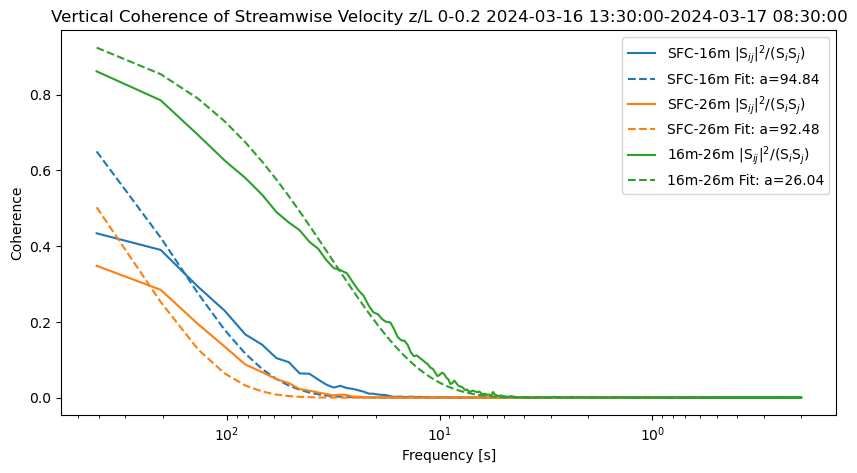

In [ ]:
fastdata['Ux']


In [19]:
fastdata = load_fastdata_nDR('/home/engbers/Documents/PhD/EC_data_convert/SFC/', 
                            period['start'], period['end'])

In [20]:
fastdata

,Ux,Uy,Uz,Ts,LI_H2Om,LI_Pres
2024-05-25 00:00:00.100,0.59325,-3.52125,0.02225,-24.91139,27.5,2273.0
2024-05-25 00:00:00.200,0.87250,-3.34800,0.21400,-25.14398,27.7,2273.0
2024-05-25 00:00:00.300,0.71825,-3.29725,0.20150,-24.55762,27.2,2302.0
2024-05-25 00:00:00.400,0.32100,-3.13975,-0.09250,-24.84380,26.6,2270.0
2024-05-25 00:00:00.500,0.41475,-3.10825,-0.01725,-24.52299,26.8,2273.0
...,...,...,...,...,...,...
2024-05-26 00:59:59.500,-1.84000,-6.20175,0.02025,-23.32278,19.4,1494.0
2024-05-26 00:59:59.600,-1.39450,-6.23325,0.32650,-23.32594,19.4,1465.0
2024-05-26 00:59:59.700,-1.40675,-6.06625,0.11100,-23.18561,19.4,1465.0
2024-05-26 00:59:59.800,-1.56800,-5.98600,0.23250,-23.18561,19.0,1465.0


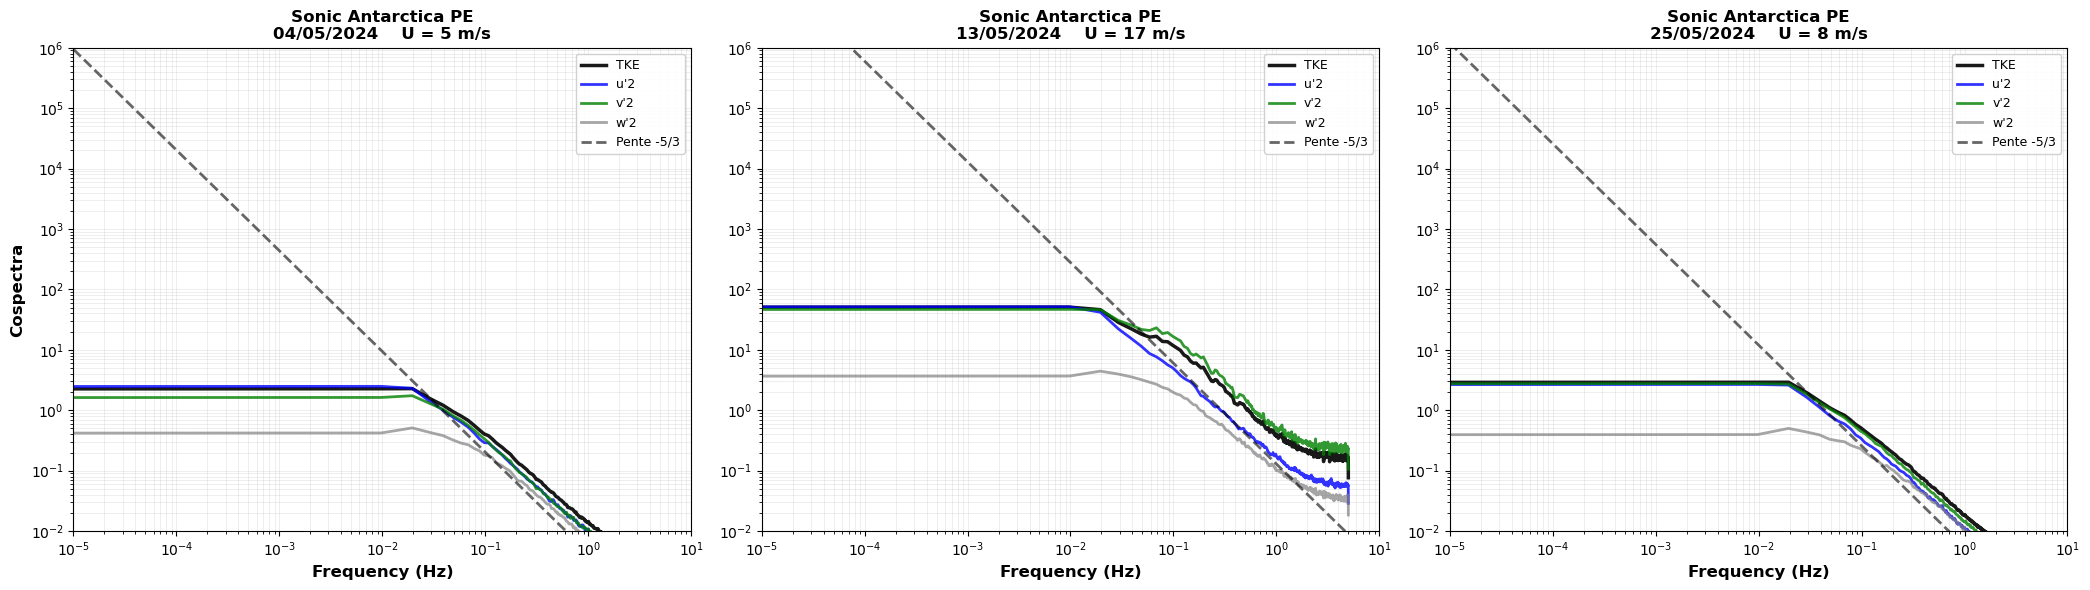

Power Spectra Statistics:


In [27]:
# Define multiple time periods to analyze
periods = [
    {'start': '2024-05-04_00:00:00', 'end': '2024-05-05_00:00:00', 'label': '04/05/2024'},
    {'start': '2024-05-13_00:00:00', 'end': '2024-05-14_00:00:00', 'label': '13/05/2024'},
    {'start': '2024-05-25_00:00:00', 'end': '2024-05-26_00:00:00', 'label': '25/05/2024'},
]

# Create multi-panel figure
n_periods = len(periods)
fig, axes = plt.subplots(1, n_periods, figsize=(7*n_periods, 6))
if n_periods == 1:
    axes = [axes]

fs = 10  # Hz
f_inertial = np.logspace(-5, 1, 100)  # Extended frequency range

# Colors matching the reference image
colors = {'TKE': 'black', 'u': 'blue', 'v': 'green', 'w': 'gray'}
labels = {'TKE': 'TKE', 'u': "u'2", 'v': "v'2", 'w': "w'2"}

for idx, period in enumerate(periods):
    ax = axes[idx]
    
    # Load data for this period
    fastdata = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_DR/', 
                             period['start'], period['end'])
    
    if fastdata.empty:
        print(f"No data for period {period['label']}")
        continue
    
    # Calculate mean wind speed
    U_mean = fastdata['Ux'].mean()
    
    # Compute power spectra
    f, Suu = welch(fastdata['Ux'].dropna(), fs=fs, nperseg=4096/4, detrend='linear')
    _, Svv = welch(fastdata['Uy'].dropna(), fs=fs, nperseg=4096/4, detrend='linear')
    _, Sww = welch(fastdata['Uz'].dropna(), fs=fs, nperseg=4096/4, detrend='linear')
    
    # Compute TKE spectrum
    S_TKE = 0.5 * (Suu + Svv + Sww)
    
    # Plot spectra
    ax.loglog(f, S_TKE, '-', linewidth=2.5, label=labels['TKE'], color=colors['TKE'], alpha=0.9)
    ax.loglog(f, Suu, '-', linewidth=2, label=labels['u'], color=colors['u'], alpha=0.8)
    ax.loglog(f, Svv, '-', linewidth=2, label=labels['v'], color=colors['v'], alpha=0.8)
    ax.loglog(f, Sww, '-', linewidth=2, label=labels['w'], color=colors['w'], alpha=0.7)
    
    # Add -5/3 reference line
    C_ref = 0.5 * S_TKE[np.argmin(np.abs(f - 0.1))] / (0.1**(-5/3))
    S_kolmogorov = C_ref * f_inertial**(-5/3)
    ax.loglog(f_inertial, S_kolmogorov, 'k--', linewidth=2, label='Pente -5/3', alpha=0.6)
    
    # Formatting
    ax.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
    if idx == 0:
        ax.set_ylabel('Cospectra', fontsize=12, fontweight='bold')
    
    # Title with location, date, and wind speed
    title = f"Sonic Antarctica PE\n{period['label']}"
    if not np.isnan(U_mean):
        title += f"    U = {U_mean:.0f} m/s"
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    # Grid and limits
    ax.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
    ax.set_xlim(1e-5, 10)
    ax.set_ylim(1e-2, 1e6)
    ax.tick_params(labelsize=10)
    
    # Legend
    ax.legend(fontsize=9, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.show()

# Print statistics for all periods
print("Power Spectra Statistics:")
print("="*80)
# for period in periods:
#     fastdata = load_fastdata_nDR('/home/engbers/Documents/PhD/EC_data_convert/SFC/', 
#                              period['start'], period['end'])
#     if not fastdata.empty:
#         U_mean = fastdata['Ux'].mean()
#         TKE_var = 0.5 * (fastdata['Ux'].var() + fastdata['Uy'].var() + fastdata['Uz'].var())
#         print(f"{period['label']:>12}: U = {U_mean:>5.2f} m/s, TKE = {TKE_var:>6.3f} m²/s²")

2m: Splitting data from 2024-05-14 00:00:00 to 2024-05-15 00:59:59.900000 into 30-minute chunks...
2m: Processed 50 chunks of 30-minute data
2m: Slope=-1.309, R²=0.9854, U_mean=9.96 m/s
16m: Splitting data from 2024-05-14 00:00:00 to 2024-05-15 00:59:59.900000 into 30-minute chunks...
16m: Processed 50 chunks of 30-minute data
16m: Slope=-1.253, R²=0.9811, U_mean=12.91 m/s
26m: Splitting data from 2024-05-14 00:00:00 to 2024-05-15 00:59:59.900000 into 30-minute chunks...
26m: Processed 50 chunks of 30-minute data
26m: Slope=-1.341, R²=0.9768, U_mean=13.55 m/s


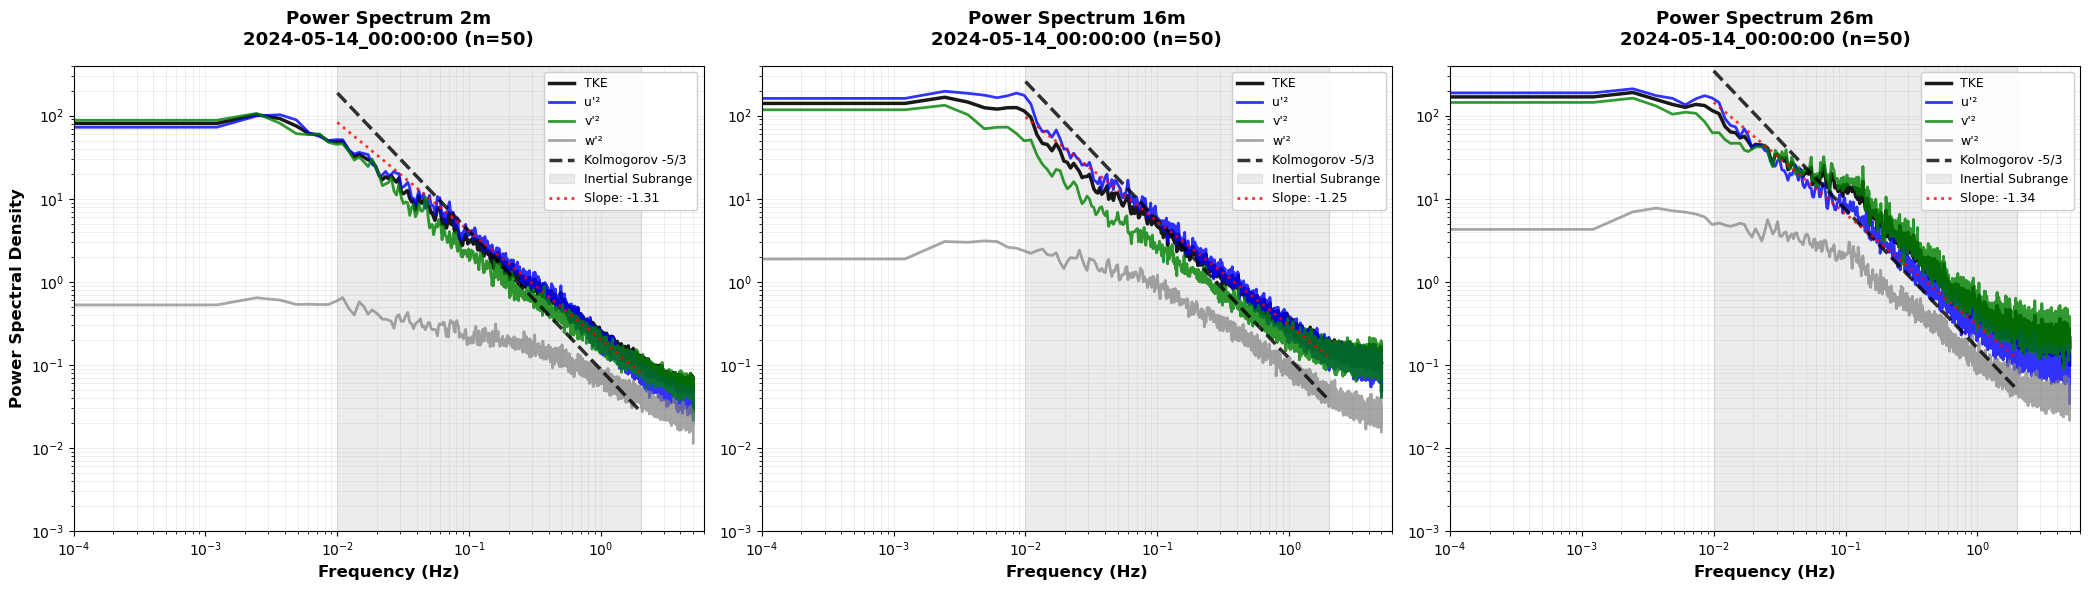

In [26]:
# Power Spectrum with Inertial Subrange and -5/3 Slope
# Load data for a single period
start='2024-05-14_00:00:00'
end='2024-05-15_00:00:00'

# Define the three heights to analyze
heights = [
    {'folder': '/home/engbers/Documents/PhD/EC_data_convert/SFC_DR/', 'label': '2m'},
    {'folder': '/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m_DR/', 'label': '16m'},
    {'folder': '/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_DR/', 'label': '26m'}
]

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for idx, height_config in enumerate(heights):
    ax = axes[idx]
    
    fastdata = load_fastdata(height_config['folder'], start, end)
    
    if not fastdata.empty:
        fs = 10  # Hz
        
        # Split data into 30-minute chunks and compute spectra for each
        chunk_duration = pd.Timedelta(minutes=30)
        start_time = fastdata.index.min()
        end_time = fastdata.index.max()
        
        # Initialize lists to store spectra
        Suu_list = []
        Svv_list = []
        Sww_list = []
        S_TKE_list = []
        
        current_time = start_time
        chunk_count = 0
        
        print(f"{height_config['label']}: Splitting data from {start_time} to {end_time} into 30-minute chunks...")
        
        while current_time < end_time:
            chunk_end = current_time + chunk_duration
            chunk_data = fastdata[(fastdata.index >= current_time) & (fastdata.index < chunk_end)]
            
            if len(chunk_data) > 4096:  # Ensure enough data for spectral analysis
                # Compute power spectra for this chunk
                f, Suu_chunk = welch(chunk_data['Ux'].dropna(), fs=fs, nperseg=8192, detrend='linear')
                _, Svv_chunk = welch(chunk_data['Uy'].dropna(), fs=fs, nperseg=8192, detrend='linear')
                _, Sww_chunk = welch(chunk_data['Uz'].dropna(), fs=fs, nperseg=8192, detrend='linear')
                S_TKE_chunk = 0.5 * (Suu_chunk + Svv_chunk + Sww_chunk)
                
                Suu_list.append(Suu_chunk)
                Svv_list.append(Svv_chunk)
                Sww_list.append(Sww_chunk)
                S_TKE_list.append(S_TKE_chunk)
                chunk_count += 1
            
            current_time = chunk_end
        
        print(f"{height_config['label']}: Processed {chunk_count} chunks of 30-minute data")
        
        # Average all spectra
        Suu = np.mean(Suu_list, axis=0)
        Svv = np.mean(Svv_list, axis=0)
        Sww = np.mean(Sww_list, axis=0)
        S_TKE = np.mean(S_TKE_list, axis=0)
        
        # Plot averaged power spectra with colors matching the reference
        colors = {'TKE': 'black', 'u': 'blue', 'v': 'green', 'w': 'gray'}
        ax.loglog(f, S_TKE, '-', linewidth=2.5, label='TKE', color=colors['TKE'], alpha=0.9)
        ax.loglog(f, Suu, '-', linewidth=2, label="u'²", color=colors['u'], alpha=0.8)
        ax.loglog(f, Svv, '-', linewidth=2, label="v'²", color=colors['v'], alpha=0.8)
        ax.loglog(f, Sww, '-', linewidth=2, label="w'²", color=colors['w'], alpha=0.7)
        
        # Define inertial subrange (typically between 0.05 Hz and 2 Hz for atmospheric turbulence)
        f_inertial_start = 0.01
        f_inertial_end = 2.0
        
        # Create frequency range for -5/3 reference line
        f_inertial = np.logspace(np.log10(f_inertial_start), np.log10(f_inertial_end), 50)
        
        # Normalize -5/3 line to match spectrum at f=0.1 Hz
        f_norm = 0.1
        idx_norm = np.argmin(np.abs(f - f_norm))
        C_ref = Suu[idx_norm] / (f_norm**(-5/3))
        S_kolmogorov = C_ref * f_inertial**(-5/3)
        
        # Plot -5/3 reference line
        ax.loglog(f_inertial, S_kolmogorov, 'k--', linewidth=2.5, 
                 label='Kolmogorov -5/3', alpha=0.8)
        
        # Highlight inertial subrange region
        ax.axvspan(f_inertial_start, f_inertial_end, alpha=0.15, color='gray', 
                  label='Inertial Subrange')
        
        # Fit a line to the inertial subrange to measure actual slope
        mask_inertial = (f >= f_inertial_start) & (f <= f_inertial_end) & (Suu > 0)
        f_fit = f[mask_inertial]
        Suu_fit = Suu[mask_inertial]
        
        # Linear regression in log-log space
        log_f = np.log10(f_fit)
        log_Suu = np.log10(Suu_fit)
        slope, intercept, r_value, p_value, std_err = linregress(log_f, log_Suu)
        
        # Plot fitted line
        S_fit = 10**intercept * f_inertial**slope
        ax.loglog(f_inertial, S_fit, 'r:', linewidth=2, 
                 label=f'Slope: {slope:.2f}', alpha=0.8)
        
        # Formatting
        ax.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
        if idx == 0:
            ax.set_ylabel("Power Spectral Density", fontsize=12, fontweight='bold')
        
        ax.set_title(f"Power Spectrum {height_config['label']}\n{start} (n={chunk_count})", 
                    fontsize=13, fontweight='bold', pad=15)
        
        ax.set_xlim(1e-4, 6)
        ax.set_ylim(1e-3, 4e2)
        ax.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=9, loc='upper right', framealpha=0.95)
        
        # Print statistics
        print(f"{height_config['label']}: Slope={slope:.3f}, R²={r_value**2:.4f}, U_mean={fastdata['Ux'].mean():.2f} m/s")
    else:
        print(f"No data available for {height_config['label']}")

plt.tight_layout()
plt.savefig(f'../plots/spectra/power_spectrum{start}_all_heights.pdf', dpi=300)
plt.show()


In [44]:
df_ep=pd.read_csv('/home/engbers/Documents/PhD/EC_data_convert/SFC_DR/Eddypro_output/202405_CS/eddypro_full_cospectra/20240504-1500_full_cospectra_2026-01-28T175151_adv.csv', skiprows=12)
df_ep

,natural_frequency,normalized_frequency,f_nat*spec(u),f_nat*spec(v),f_nat*spec(w)
0,0.002441,0.000877,0.259711,0.170984,0.017781
1,0.004883,0.001753,0.143395,0.016039,0.010413
2,0.007324,0.002630,0.160984,0.487566,0.050049
3,0.009766,0.003506,0.512336,0.316092,0.016878
4,0.012207,0.004383,0.304660,0.005738,0.005572
...,...,...,...,...,...
2043,4.990230,1.791780,0.070477,0.010126,0.106019
2044,4.992680,1.792660,0.028051,0.097570,0.049235
2045,4.995120,1.793540,0.019972,0.519468,0.047719
2046,4.997560,1.794410,0.023621,0.025198,0.366285


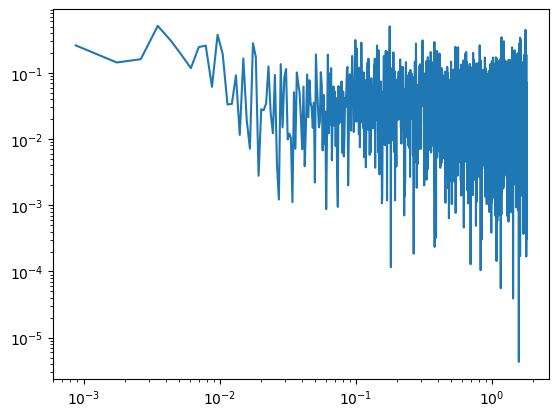

In [45]:
plt.plot(df_ep['normalized_frequency'], df_ep['f_nat*spec(u)'])
plt.xscale('log')
plt.yscale('log')

In [ ]:
fs=10
def plot_coherence(u1, u2, dz, label, color=None):
    u1_clean, u2_clean = u1.align(u2, join='inner')
    mask = (~u1_clean.isna()) & (~u2_clean.isna())
    u1_clean = u1_clean[mask]
    u2_clean = u2_clean[mask]

    f, S11 = welch(u1_clean, fs=fs, nperseg= 4096)
    _, S22 = welch(u2_clean, fs=fs, nperseg= 4096)
    _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg= 4096)
    coh = np.abs(S12)**2 / (S11 * S22)

    u_mean = ((u1_clean + u2_clean) / 2).mean()
    def model(f, a):
        return np.exp(-a * dz * f / u_mean)

    mask_fit = np.isfinite(coh) & np.isfinite(f)
    popt, _ = curve_fit(model, f[mask_fit], coh[mask_fit], p0=[1.0])
    a_best = popt[0]
    y = model(f, a_best)

    # Convert frequency to period in seconds, avoid division by zero
    period = np.where(f > 0, 1 / f, np.nan)
    plt.semilogx(period, coh, label=fr'{label} $|\mathrm{{S}}_{{ij}}|^2/(\mathrm{{S}}_i \mathrm{{S}}_j)$', color=color)
    plt.semilogx(period, y, '--', label=f'{label} Fit: a={a_best:.2f}', color=color)
    plt.gca().invert_xaxis()


plt.figure(figsize=(10, 5))
plot_coherence(fastdata_SFC['Ux'], fastdata_16['Ux'], dz=14, label='SFC-16m', color='tab:blue')
plot_coherence(fastdata_SFC['Ux'], fastdata_26['Ux'], dz=24, label='SFC-26m', color='tab:orange')
plot_coherence(fastdata_16['Ux'], fastdata_26['Ux'], dz=10, label='16m-26m', color='tab:green')
plt.xlabel('Frequency [s]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity')
plt.legend()
plt.show()


NameError: name 'fastdata_SFC' is not defined

<Figure size 1000x500 with 0 Axes>

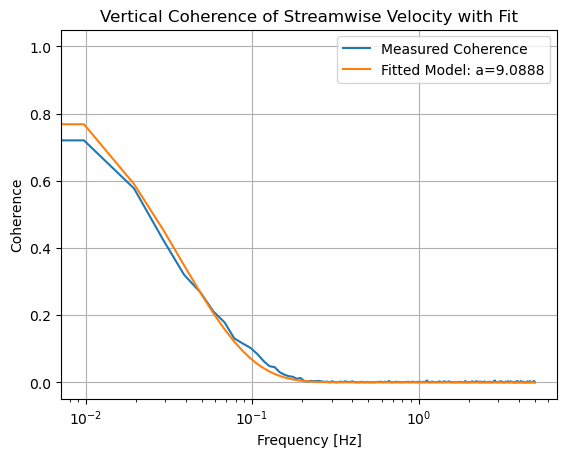

In [ ]:

dz=14
u_mean= ((fastdata_SFC['Ux']+ fastdata_16['Ux'])/2).mean()
def model(f, a):
    return np.exp(-a * dz * f / u_mean)

# Use only the valid (finite) values for curve fitting
mask_fit = np.isfinite(coh) & np.isfinite(f)
popt, pcov = curve_fit(model, f, coh, p0=[1.0])
a_best = popt[0]
y = model(f, a_best)
plt.semilogx(f, coh, label='Measured Coherence')
plt.semilogx(f, y,label=f'Fitted Model: a={a_best:.4f}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity with Fit')
plt.legend()
plt.grid(True)

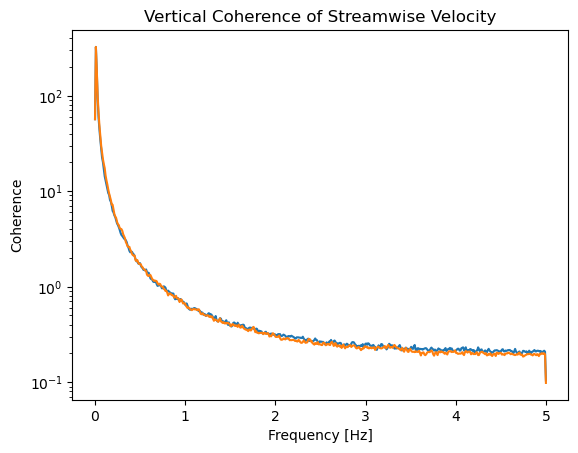

In [ ]:
plt.semilogy(f, S11/w_var1**2, label='S11')
plt.semilogy(f, S22/w_var1**2, label='S22')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity')
plt.show()